### Context
This projects goal is to develop a blood test that can diagnose humans with Chagas Disease. Chagas Disease is a currently undiagnosable disease common in Latin American countries, causing 3 million deaths each year. Researchers at the University of Texas Medical Branch have identified **12 protein paramters** or genes that react to the presence of Chagas Disease. In addition to the protein paramters, **6 Mitochondrial DNA** types have also been identified as Chagas Disease reactants.

These 12 Protein Parameters and 6 Mitochondrial DNA Types are called 'Biomarkers' and they will be used as continuous features to predict the categorical outcome 'Symptom', as seen in the dataset below.


There are 3 Symptom Statuses (classifiations) of human subjects.

**NHS**: Normal Healthy Subjects who do not have Chagas Disease

**SYM**  :  Symptomatic Subjects who have Chagas Disease.

**ASYM** : Asymptomatic Subjects who have Chagas Disease.


Our data set includes blood samples from 42 subjects. 12 subjects were NHS, 15 were Symptomatic and 15 were Asymptomatic. Each subject has had their 12 protein paramters expressions quantifiied in a unit of measurement called 'folds'. Similarly, the 6 Mitochondrial DNA Types were also measured for each of the 42 subjects.

Protein Parameter expression is derived from 2 types of blood sampling: Serum and Plasma. Each of the 12 Protein Parameters are measured in Plasma and Serum, making 24 unique measurements in total. Plasma samples and Serum samples will be treated as seperate biomarkers.

For example, the Protein Parameter Copeptin_Serum is a seperate feature than Copeptin_Plasma.


### Hypothesis
Biomarkers that can classify a NHS record from a Symptomatic or Asymptomatic record are "**Diagnostic**" Biomarkers.

Biomarkers that can classify a Symptomatic record from an Asymptomatic record are "**Prognostic**" Biomarkers.

Null Hypothesis: The Biomarkers cannot distinguish between NHS subjects or Symptomatic Subjects.

Alternative Hypothesis: The Biomarkers can distringuish between NHS subjects or Symptomatic Subjects.

In [10]:
import sys
from pathlib import Path

# Resolve the absolute path to src folder
src_path = Path('../src').resolve()  # relative from notebook folder
sys.path.append(str(src_path))

# Now you can import train_auc
import train, eda


In [11]:

# Data handling & I/O
import pandas as pd
import numpy as np

# Statistical modeling & machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
from plotnine import (  # I miss R
    ggplot, aes, geom_line, geom_abline, labs,geom_boxplot, facet_wrap, theme, scale_fill_manual)


The dataset below shows the raw data derived from Latin American patients. Information about each subject such as Sex, Age, and Country of residents was not provided by my research team.

**ID**: Refers to the human subject whose information is in the row.

**Moleculae**: The name of the protein parameter measured.

**Symptom**: The symptom status of the human subject (ID). NHS refers to Normal Healthy Subjects (do not have Chagas Disease). SYM refers to subjects that have Chagas Disease and show symptoms. ASYM refers to Chagas Disease patients that do not have symptoms.

**Serum**: Serum is a component of blood from which the Moleculae experssion is measured.

**Plasma**: Plasma is another component of blood from which the Moleculae experssion is measured.

In [12]:
propar_df = pd.read_excel("../data/proteinparam.xlsx")
print(propar_df.head(),'\n',propar_df.tail())

   ID Moleculae Symptom     Serum    Plasma
0   1  Copeptin     NHS  249.6529  165.2295
1   2  Copeptin     NHS  155.8492  209.0046
2   3  Copeptin     NHS  212.1314  255.9064
3   4  Copeptin     NHS  287.1744  212.1314
4   5  Copeptin     NHS  343.4566  337.2030 
      ID Moleculae Symptom     Serum    Plasma
247  38     PARP1     SYM  107.2179  215.0518
248  39     PARP1     SYM  169.3924  165.9922
249  40     PARP1     SYM  294.2271  220.3949
250  41     PARP1     SYM  341.3436  124.7045
251  42     PARP1     SYM  224.2808  312.6851


The Mitochondrial DNA set shows 6 biomarkers and their expression in each human subject.

In [13]:
mtdna_df = pd.read_excel("../data/MitochondrialDNA.xlsx")
print(mtdna_df.head(),'\n',mtdna_df.tail())


  Symptom     mtND1      mtND5    mtATP6     mtCOII     mtCytB
0     NHS  2.299503   1.077283  0.619246  11.138046  17.201804
1     NHS  1.392381   2.262226  1.224188  24.055866  34.887110
2     NHS  2.466687   4.289404  1.304040  27.882326  41.747166
3     NHS  4.907632  17.707490  4.186171  21.671302  13.607458
4     NHS  2.044490   4.958839  1.951089   9.727539   7.873829 
           Symptom       mtND1      mtND5      mtATP6      mtCOII      mtCytB
37  Symptomatic C   51.170069  27.964367   76.746221   42.600922   80.231516
38  Symptomatic C   55.337050  28.179157   73.584781   44.912786   65.716738
39  Symptomatic C  170.789434  94.006092  224.781208  158.106600  251.966614
40  Symptomatic C  105.394513  55.872487  113.722658   88.966601  113.562776
41  Symptomatic C  105.827369  86.615975  159.746003   88.357211  131.801089


### Data Manipulation
1. Create features, 'markers', for each combination of Moleculae and Serum or Plasma type. ex. Copeptin_Serum, Copeptin_Plasma.

2. Covert from long format to wide format so each marker can be treated as a feature column for upcoming models.

3. Create dummy variables. NHS=1, NHS=0 to classify NHS from SYM and ASYM.

4. Create dummy variable. SYM=1, SYM=0 to classify Symptoamatic from Asymptomatic.

5. Remove any duplicates and remove empty rows.

In [14]:
# Each protein parameter becomes its own ser/plas column
propar_df_wide = propar_df.pivot(index = 'ID', columns =  'Moleculae', values = ['Serum','Plasma'])
propar_df_wide.columns = [f"{col[1]}_{col[0]}" for col in propar_df_wide.columns]

# Organize rows by symptom status. NHS (topmost), ASYM(middle), SYM(bottom most)
propar_df_wide = propar_df_wide.merge(propar_df[['ID', 'Symptom']], on = 'ID', how = 'left')

# Create dummy variable column for Chagas Disease 0/1
propar_df_wide['NHS'] = np.where(propar_df_wide['Symptom'] == 'NHS', 0,
                                  np.where(propar_df_wide['Symptom'].isin(['ASYM','SYM']), 1, np.nan))

# Create dummy vairable column for Symptom Status 0 for Asymptomatic/1 for Symptomatic.
# Nan for NHS Normal Healthy Subject
propar_df_wide['SYM'] = np.where(propar_df_wide['Symptom'] == 'ASYM', 0,
                                    np.where(propar_df_wide['Symptom'] == 'SYM', 1, np.nan))

df_wide = propar_df_wide

df_wide = df_wide.drop_duplicates()


# Create a list of columns that are protein paramters
fixed_vars = ["ID", "Symptom", "NHS", "SYM"]
proteinparam_vars = [col for col in df_wide.columns if col.endswith("_Serum") or col.endswith("_Plasma")]

protein_paramters_long = df_wide.melt(
    id_vars = fixed_vars,
    value_vars = proteinparam_vars,
    var_name = 'Marker',
    value_name = 'Value'
)

# Remove duplicate records
protein_parameters_long = protein_paramters_long.drop_duplicates()
# Remove empty records that used to be duplicates
protein_parameters_long = protein_parameters_long.reset_index(drop=True)
# I got an error caused by <NaN> so I converted the int values to strings
protein_parameters_long['SYM'] = protein_parameters_long['SYM'].astype('Int64').astype(str).replace({'0': 'Sym', '1': 'Asym', '<NA>': 'NHS'})

print(protein_parameters_long.head(),'\n',protein_parameters_long.tail())

   ID Symptom  NHS  SYM          Marker     Value
0   1     NHS  0.0  NHS  Copeptin_Serum  249.6529
1   2     NHS  0.0  NHS  Copeptin_Serum  155.8492
2   3     NHS  0.0  NHS  Copeptin_Serum  212.1314
3   4     NHS  0.0  NHS  Copeptin_Serum  287.1744
4   5     NHS  0.0  NHS  Copeptin_Serum  343.4566 
      ID Symptom  NHS   SYM         Marker     Value
499  38     SYM  1.0  Asym  etOhDG_Plasma  30.02026
500  39     SYM  1.0  Asym  etOhDG_Plasma  25.55615
501  40     SYM  1.0  Asym  etOhDG_Plasma  26.00023
502  41     SYM  1.0  Asym  etOhDG_Plasma  29.31909
503  42     SYM  1.0  Asym  etOhDG_Plasma  28.54781


In [15]:
# Fix Typos and shorten name for labels
mtdna_df['Symptom'] = mtdna_df['Symptom'].replace({
    'Asymptomatic C': 'ASYM',
    'Symptomatic C': 'SYM',
    'Asym': 'ASYM',
    'Sym': 'SYM',
})

# Dummy variable for Symptomatic: 1 if SYM, 0 if ASYM, NaN otherwise
mtdna_df['SYM'] = np.where(mtdna_df['Symptom'] == 'ASYM', 0,
                            np.where(mtdna_df['Symptom'] == 'SYM', 1, np.nan))

# Dummy variable for NHS: 0 if NHS, 1 if ASYM or SYM, NaN otherwise
mtdna_df['NHS'] = np.where(mtdna_df['Symptom'] == 'NHS', 0,
                           np.where(mtdna_df['Symptom'].isin(['ASYM','SYM']), 1, np.nan))

# Melt for long-format plotting
mtdna_long = mtdna_df.melt(
    id_vars='Symptom',          # columns to keep
    var_name='Marker',          # new column name for melted variable headers
    value_name='Value'          # new column name for melted values
)

# Remove dummy columns from the melted data
mtdna_long = mtdna_long[~mtdna_long['Marker'].isin(['NHS','SYM'])]

# Log-transform values for better visualization
mtdna_long['log_values'] = np.log(mtdna_long['Value'])

print(mtdna_df.head(),'\n',mtdna_df.tail())
print(mtdna_long.head(),'\n',mtdna_long.tail())

  Symptom     mtND1      mtND5    mtATP6     mtCOII     mtCytB  SYM  NHS
0     NHS  2.299503   1.077283  0.619246  11.138046  17.201804  NaN  0.0
1     NHS  1.392381   2.262226  1.224188  24.055866  34.887110  NaN  0.0
2     NHS  2.466687   4.289404  1.304040  27.882326  41.747166  NaN  0.0
3     NHS  4.907632  17.707490  4.186171  21.671302  13.607458  NaN  0.0
4     NHS  2.044490   4.958839  1.951089   9.727539   7.873829  NaN  0.0 
    Symptom       mtND1      mtND5      mtATP6      mtCOII      mtCytB  SYM  \
37     SYM   51.170069  27.964367   76.746221   42.600922   80.231516  1.0   
38     SYM   55.337050  28.179157   73.584781   44.912786   65.716738  1.0   
39     SYM  170.789434  94.006092  224.781208  158.106600  251.966614  1.0   
40     SYM  105.394513  55.872487  113.722658   88.966601  113.562776  1.0   
41     SYM  105.827369  86.615975  159.746003   88.357211  131.801089  1.0   

    NHS  
37  1.0  
38  1.0  
39  1.0  
40  1.0  
41  1.0  
  Symptom Marker     Value  log

### Exploratory Data Analysis

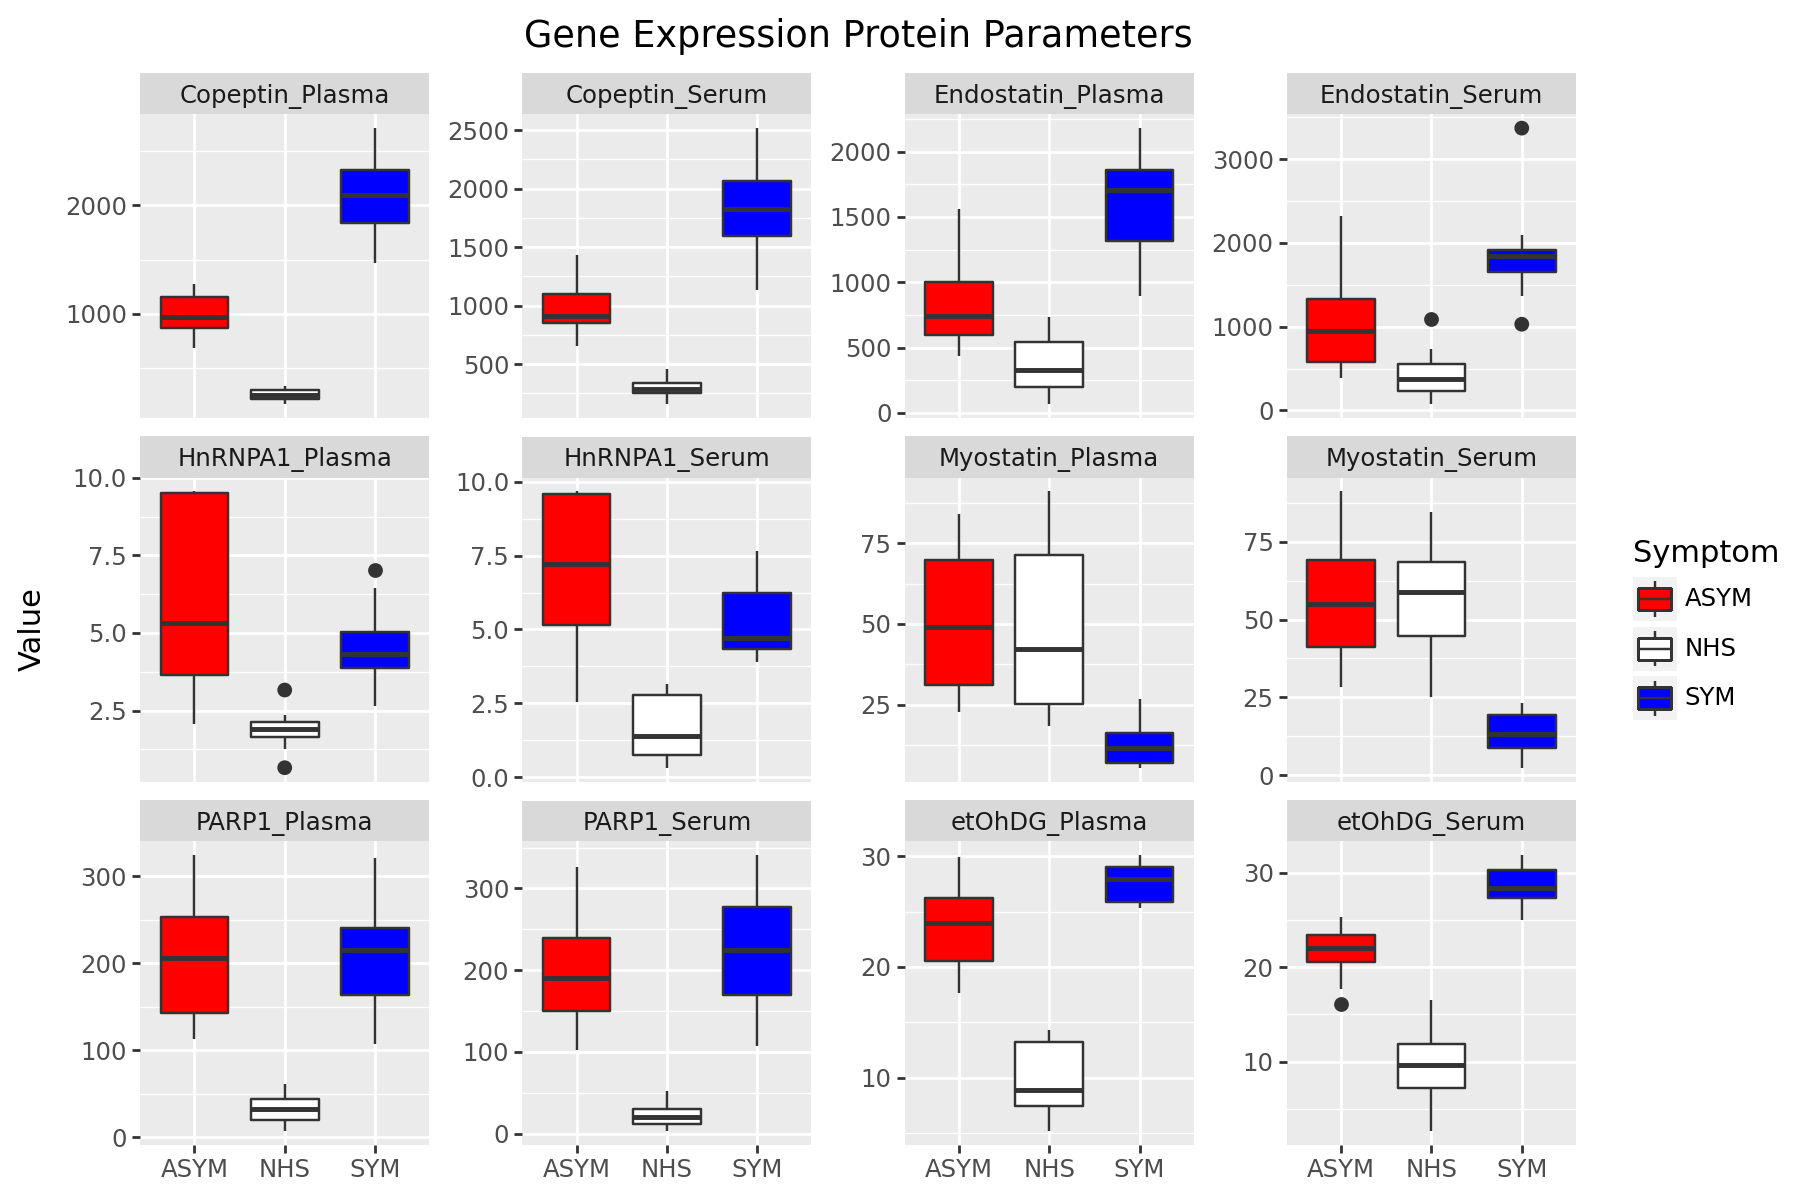

In [16]:
eda.boxplot(protein_parameters_long, 'Marker', 'Value', 'Symptom', 'Gene Expression Protein Parameters', 4)

The boxplots alone are extremely telling as to what biomarker can classify which symptom status. Several notes:

1. Plasma and Serum mean values are within eachothers IQR, with the exception of Endostatins Asymptomatic records. This indicates that there is not an extreme difference between taking data from Plasma versus taking data from Serum. 

2. The relavtive shapes of each symptom status are the same between serum and plasma pairs. For example Myostatin Serum & Myostatin Plasma have boxplots of similar positions to eachother even though the sizes vary. 

3. Most NHS records have IQRs completely out of the range of their counter part Asym and Sym IQRs. This indiactes strong diagnostic predictive power for most Protein Parameters.

4. Less common, are Asym and Sym IQRs that are completely outside of eachothers range. This also indiactes strong prognostic predicitive power. For example Copeptin Plasma has strong prognostic power because there is no overlap between ASYM and SYM values.

5. Overlapping Sym and Asym results will have weak prognostic predictive power or none at all. Overlapping NHS IQRs will have weak diagnostic predicitive power.

Evaluation procedures that come to mind are AUC and Cross Validation. AUC will give perfect 1s to most Diagnostic tests since there is no overlap in NHS and the other boxplots. However AUC will come in handy for testing biomarkers without a perfect split. 
Cross Validation can be used to test the robustness of these seemingly perfect splits. Copeptin Serum for example has overlap in max and min values.


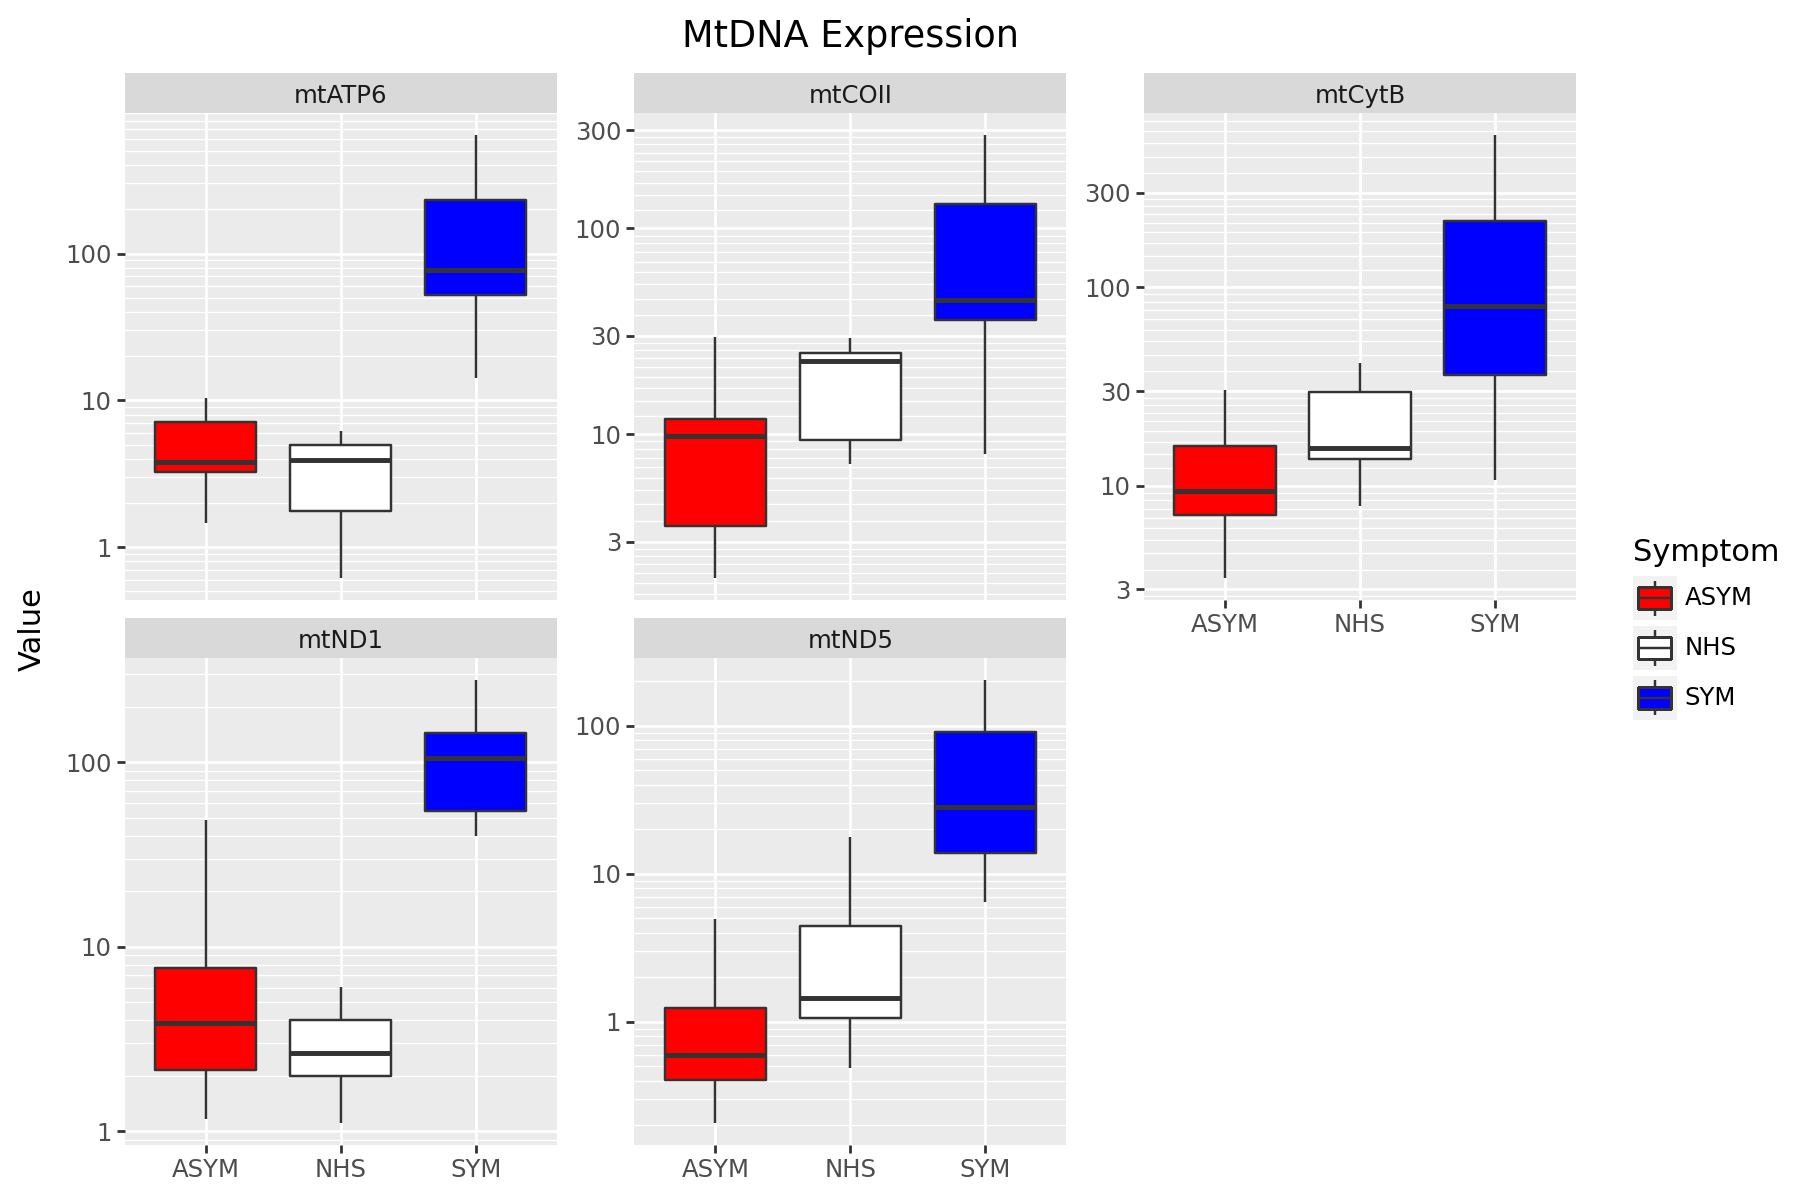

In [17]:
#eda.boxplot(mtdna_long,'Marker','Value','Symptom','MtDNA Expression')
eda.boxplot(mtdna_long,'Marker','Value','Symptom','MtDNA Expression', 3, True)

### Logistic Regression & Evaluation: Protein Parameters




We will create Logistic Regression Models to determine if a biomarker is diagnostic or prognostic.

1. Create Logisitic Regression models that use Protein Parameters to classify NHS subjects.
Determine Diagnostic potential by evaluating ROC curve AUC.

2. Create Logisitic Regression models that use Protein Parameters to classify Symptomatic or Asymptomatic subjects.
Determine Pronostic potential by evaluating ROC curve AUC.

3. Create Logisitic Regression models that use Mitochondrial DNA to classify NHS subjects.
Determine Diagnostic potential by evaluating ROC curve AUC.

4. Create Logisitic Regression models that use Mitochondrial DNA: to classify Symptomatic or Asymptomatic subjects.
Determine Pronostic potential by evaluating ROC curve AUC.





In [18]:
# Lets store the AUC values for each biomarker in a dataframe
pp_auc_df = pd.DataFrame(columns = list(df_wide.columns))
mtdna_auc_df = pd.DataFrame(columns = list(mtdna_df.columns))

nhs_pp_auc_df = pp_auc_df.drop(['ID','Symptom', 'NHS', 'SYM'], axis=1)
sym_pp_auc_df = pp_auc_df.drop(['ID','Symptom', 'NHS', 'SYM'], axis=1)
nhs_mtdna_auc_df = mtdna_auc_df.drop(['Symptom', 'NHS', 'SYM'], axis=1)
sym_mtdna_auc_df = mtdna_auc_df.drop(['Symptom', 'NHS', 'SYM'], axis=1)



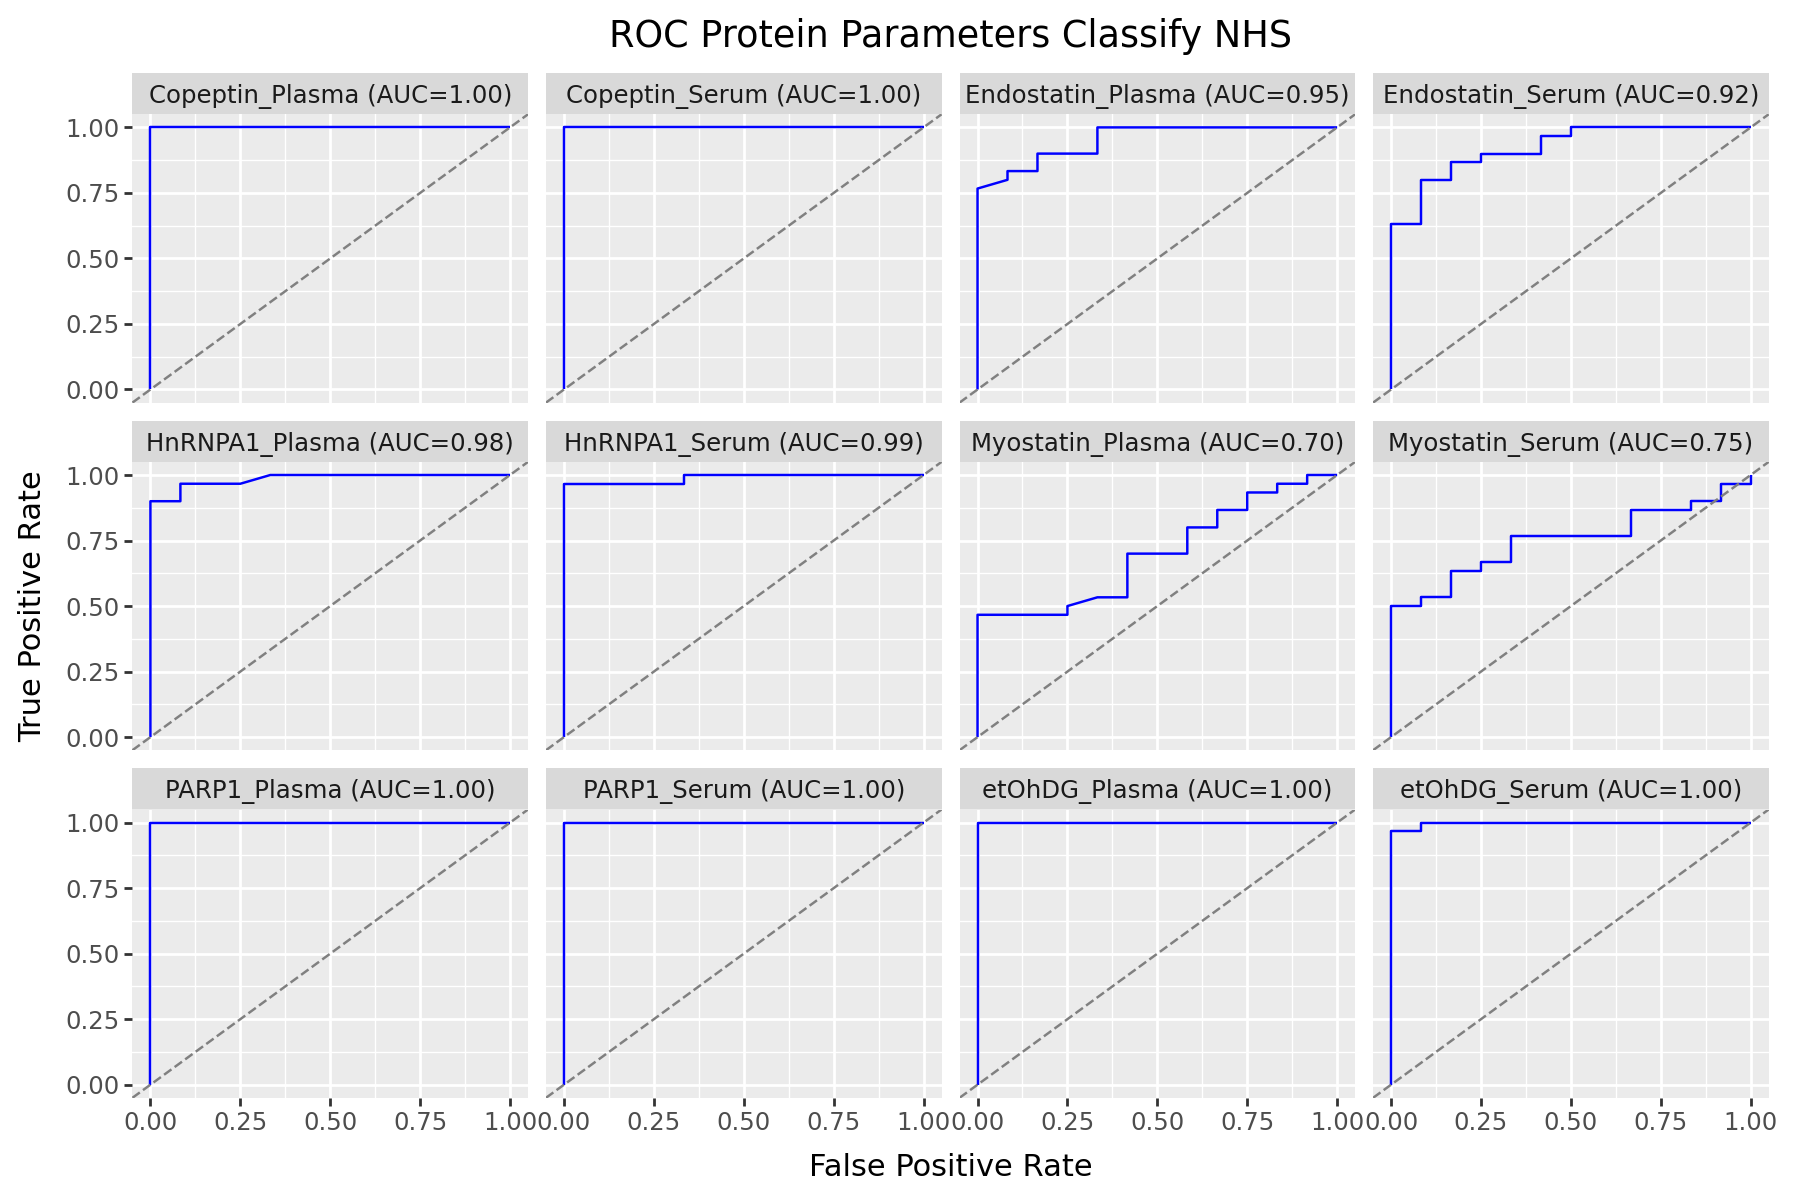

,Copeptin_Serum,Endostatin_Serum,HnRNPA1_Serum,Myostatin_Serum,PARP1_Serum,etOhDG_Serum,Copeptin_Plasma,Endostatin_Plasma,HnRNPA1_Plasma,Myostatin_Plasma,PARP1_Plasma,etOhDG_Plasma
0,1.0,0.922222,0.988889,0.75,1.0,0.997222,1.0,0.951389,0.984722,0.701389,1.0,1.0


In [19]:
# Create Logistic Regression Models and ROC Curves for each Protein Parameter
# Chagas vs NHS
import sklearn 
from sklearn.linear_model import LogisticRegression

train.setup()

# Loop through proteins
for propar in train.protein_parameters:
    nhs_pp_auc_df.loc[0, propar] = train.chagasLogReg(df_wide,'NHS',propar)

train.print_ROC(nhs_pp_auc_df,'~Biomarker', "ROC Protein Parameters Classify NHS")

nhs_pp_auc_df


In [20]:
roc_all = []

nhs_pp_cv_df = pd.DataFrame(columns=['Biomarker', 'NHS Mean AUC', 'Std AUC'])

# Loop through protein parameters
for propar in train.protein_parameters:
    mean_auc, std_auc = train.chagasLogReg_CV(df_wide, outcome='NHS', biomarker=propar, n_splits=5)
    nhs_pp_cv_df.loc[len(nhs_pp_cv_df)] = [propar, mean_auc, std_auc]
    print(f"{propar}: Mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

# Show summary table
nhs_pp_cv_df



Copeptin_Serum: Mean AUC=1.000 ± 0.000
Endostatin_Serum: Mean AUC=0.911 ± 0.085
HnRNPA1_Serum: Mean AUC=0.978 ± 0.044
Myostatin_Serum: Mean AUC=0.778 ± 0.172
PARP1_Serum: Mean AUC=1.000 ± 0.000
etOhDG_Serum: Mean AUC=1.000 ± 0.000
Copeptin_Plasma: Mean AUC=1.000 ± 0.000
Endostatin_Plasma: Mean AUC=0.950 ± 0.067
HnRNPA1_Plasma: Mean AUC=0.983 ± 0.033
Myostatin_Plasma: Mean AUC=0.694 ± 0.250
PARP1_Plasma: Mean AUC=1.000 ± 0.000
etOhDG_Plasma: Mean AUC=1.000 ± 0.000


,Biomarker,NHS Mean AUC,Std AUC
0,Copeptin_Serum,1.000000,0.000000
1,Endostatin_Serum,0.911111,0.084984
2,HnRNPA1_Serum,0.977778,0.044444
3,Myostatin_Serum,0.777778,0.172133
4,PARP1_Serum,1.000000,0.000000
5,etOhDG_Serum,1.000000,0.000000
6,Copeptin_Plasma,1.000000,0.000000
7,Endostatin_Plasma,0.950000,0.066667
8,HnRNPA1_Plasma,0.983333,0.033333
9,Myostatin_Plasma,0.694444,0.249691


In [21]:
# Create new dataframes that removes NaN in the SYM Columnprint(sklearn.__version__)
df_sym = df_wide.dropna()
df_sym = df_sym.drop_duplicates()
df_sym

mtdna_sym = mtdna_df.dropna()
mtdna_sym = mtdna_sym.drop_duplicates()

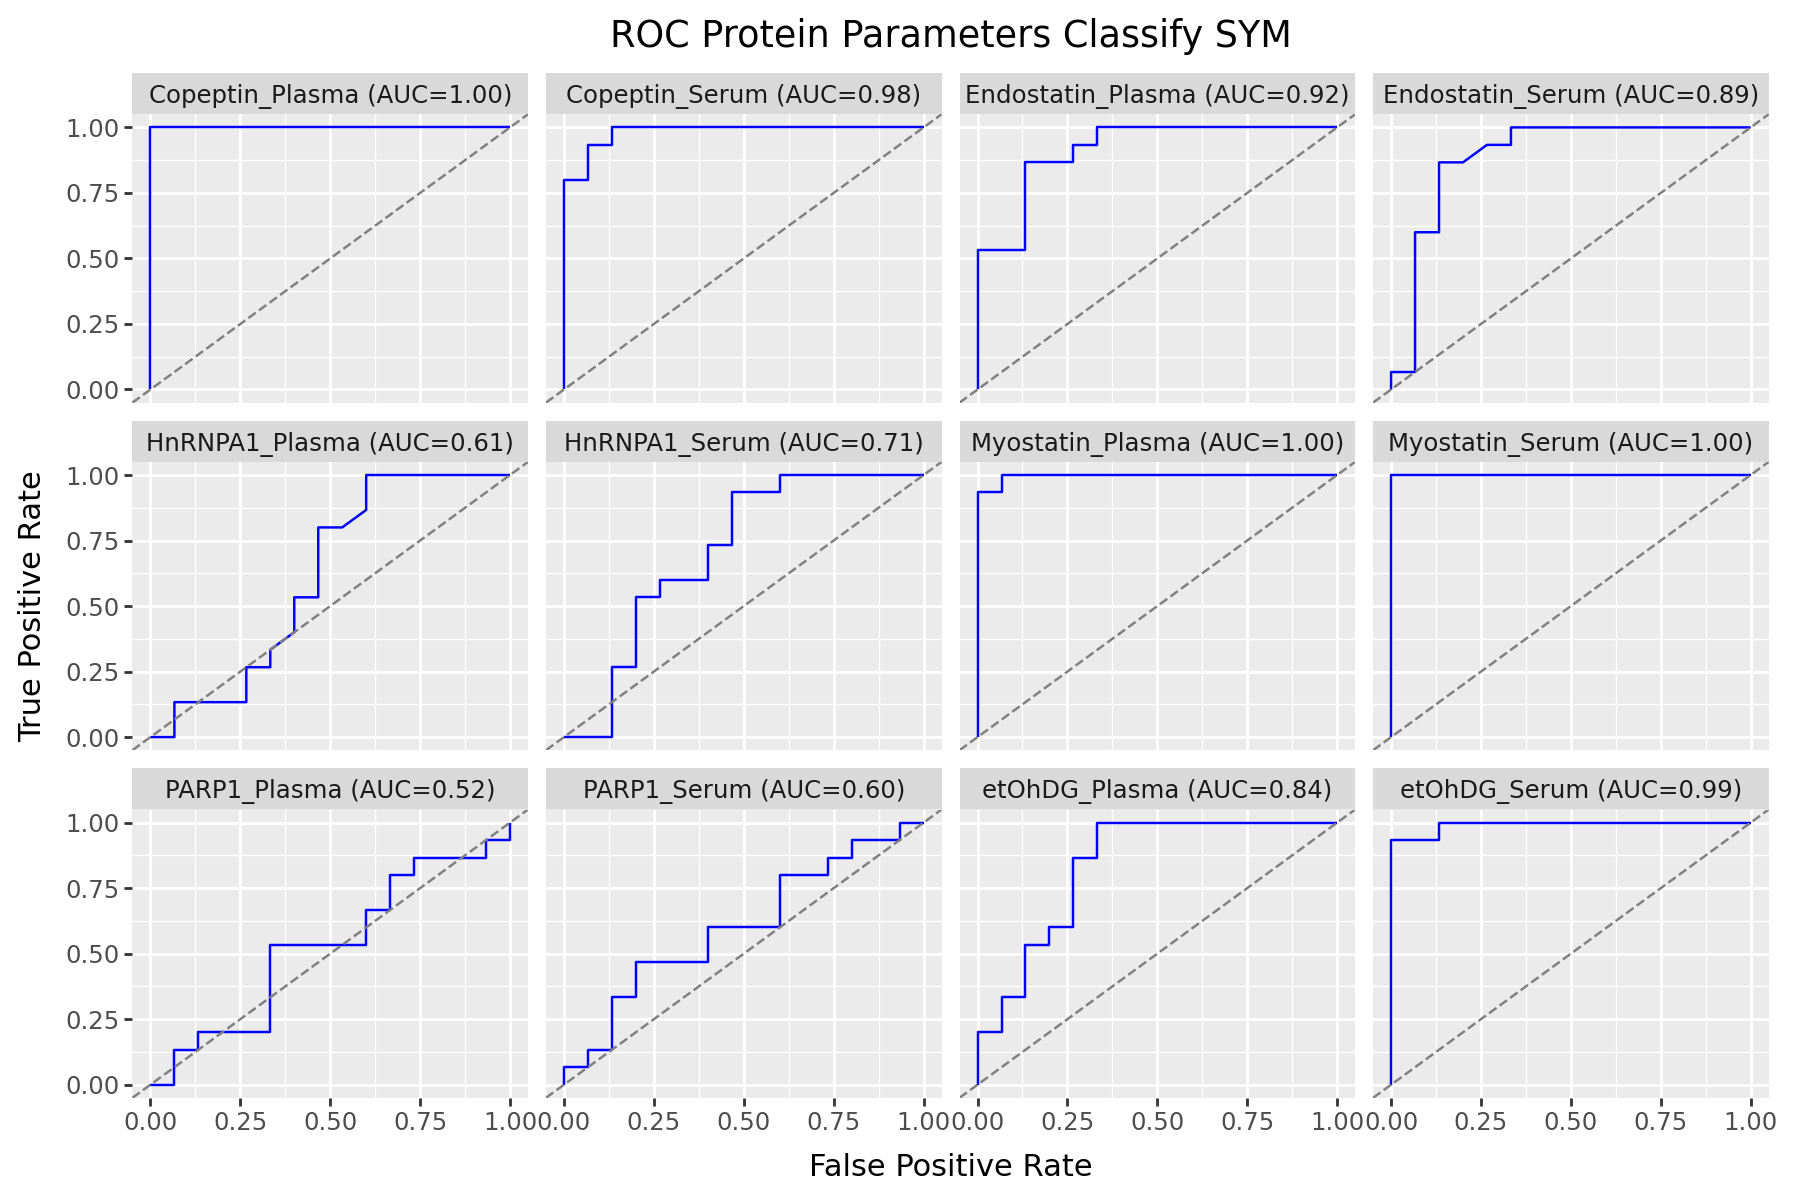

,Copeptin_Serum,Endostatin_Serum,HnRNPA1_Serum,Myostatin_Serum,PARP1_Serum,etOhDG_Serum,Copeptin_Plasma,Endostatin_Plasma,HnRNPA1_Plasma,Myostatin_Plasma,PARP1_Plasma,etOhDG_Plasma
0,0.982222,0.891111,0.706667,1.0,0.604444,0.991111,1.0,0.915556,0.613333,0.995556,0.524444,0.835556


In [22]:
# Create Logistic Regression Models and ROC Curves for each Protein Parameter
# Symptomatic vs Asymptomatic

train.setup()

for propar in train.protein_parameters:
    sym_pp_auc_df.loc[0, propar] = train.chagasLogReg(df_sym,'SYM',propar)

train.print_ROC(sym_pp_auc_df,'~Biomarker', "ROC Protein Parameters Classify SYM")
sym_pp_auc_df

In [23]:
roc_all = []

sym_pp_cv_df = pd.DataFrame(columns=['Biomarker', 'SYM Mean AUC', 'Std AUC'])

# Loop through protein parameters
for propar in train.protein_parameters:
    mean_auc, std_auc = train.chagasLogReg_CV(df_sym, outcome='SYM', biomarker=propar, n_splits=5)
    sym_pp_cv_df.loc[len(sym_pp_cv_df)] = [propar, mean_auc, std_auc]
    print(f"{propar}: Mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

# Show summary table
sym_pp_cv_df


Copeptin_Serum: Mean AUC=0.978 ± 0.044
Endostatin_Serum: Mean AUC=0.900 ± 0.200
HnRNPA1_Serum: Mean AUC=0.689 ± 0.361
Myostatin_Serum: Mean AUC=1.000 ± 0.000
PARP1_Serum: Mean AUC=0.733 ± 0.206
etOhDG_Serum: Mean AUC=1.000 ± 0.000
Copeptin_Plasma: Mean AUC=1.000 ± 0.000
Endostatin_Plasma: Mean AUC=0.911 ± 0.130
HnRNPA1_Plasma: Mean AUC=0.689 ± 0.044
Myostatin_Plasma: Mean AUC=0.978 ± 0.044
PARP1_Plasma: Mean AUC=0.244 ± 0.147
etOhDG_Plasma: Mean AUC=0.778 ± 0.122


,Biomarker,SYM Mean AUC,Std AUC
0,Copeptin_Serum,0.977778,0.044444
1,Endostatin_Serum,0.900000,0.200000
2,HnRNPA1_Serum,0.688889,0.361068
3,Myostatin_Serum,1.000000,0.000000
4,PARP1_Serum,0.733333,0.206080
5,etOhDG_Serum,1.000000,0.000000
6,Copeptin_Plasma,1.000000,0.000000
7,Endostatin_Plasma,0.911111,0.129577
8,HnRNPA1_Plasma,0.688889,0.044444
9,Myostatin_Plasma,0.977778,0.044444


### Logistic Regression & Evaluation: Mitochondrial DNA

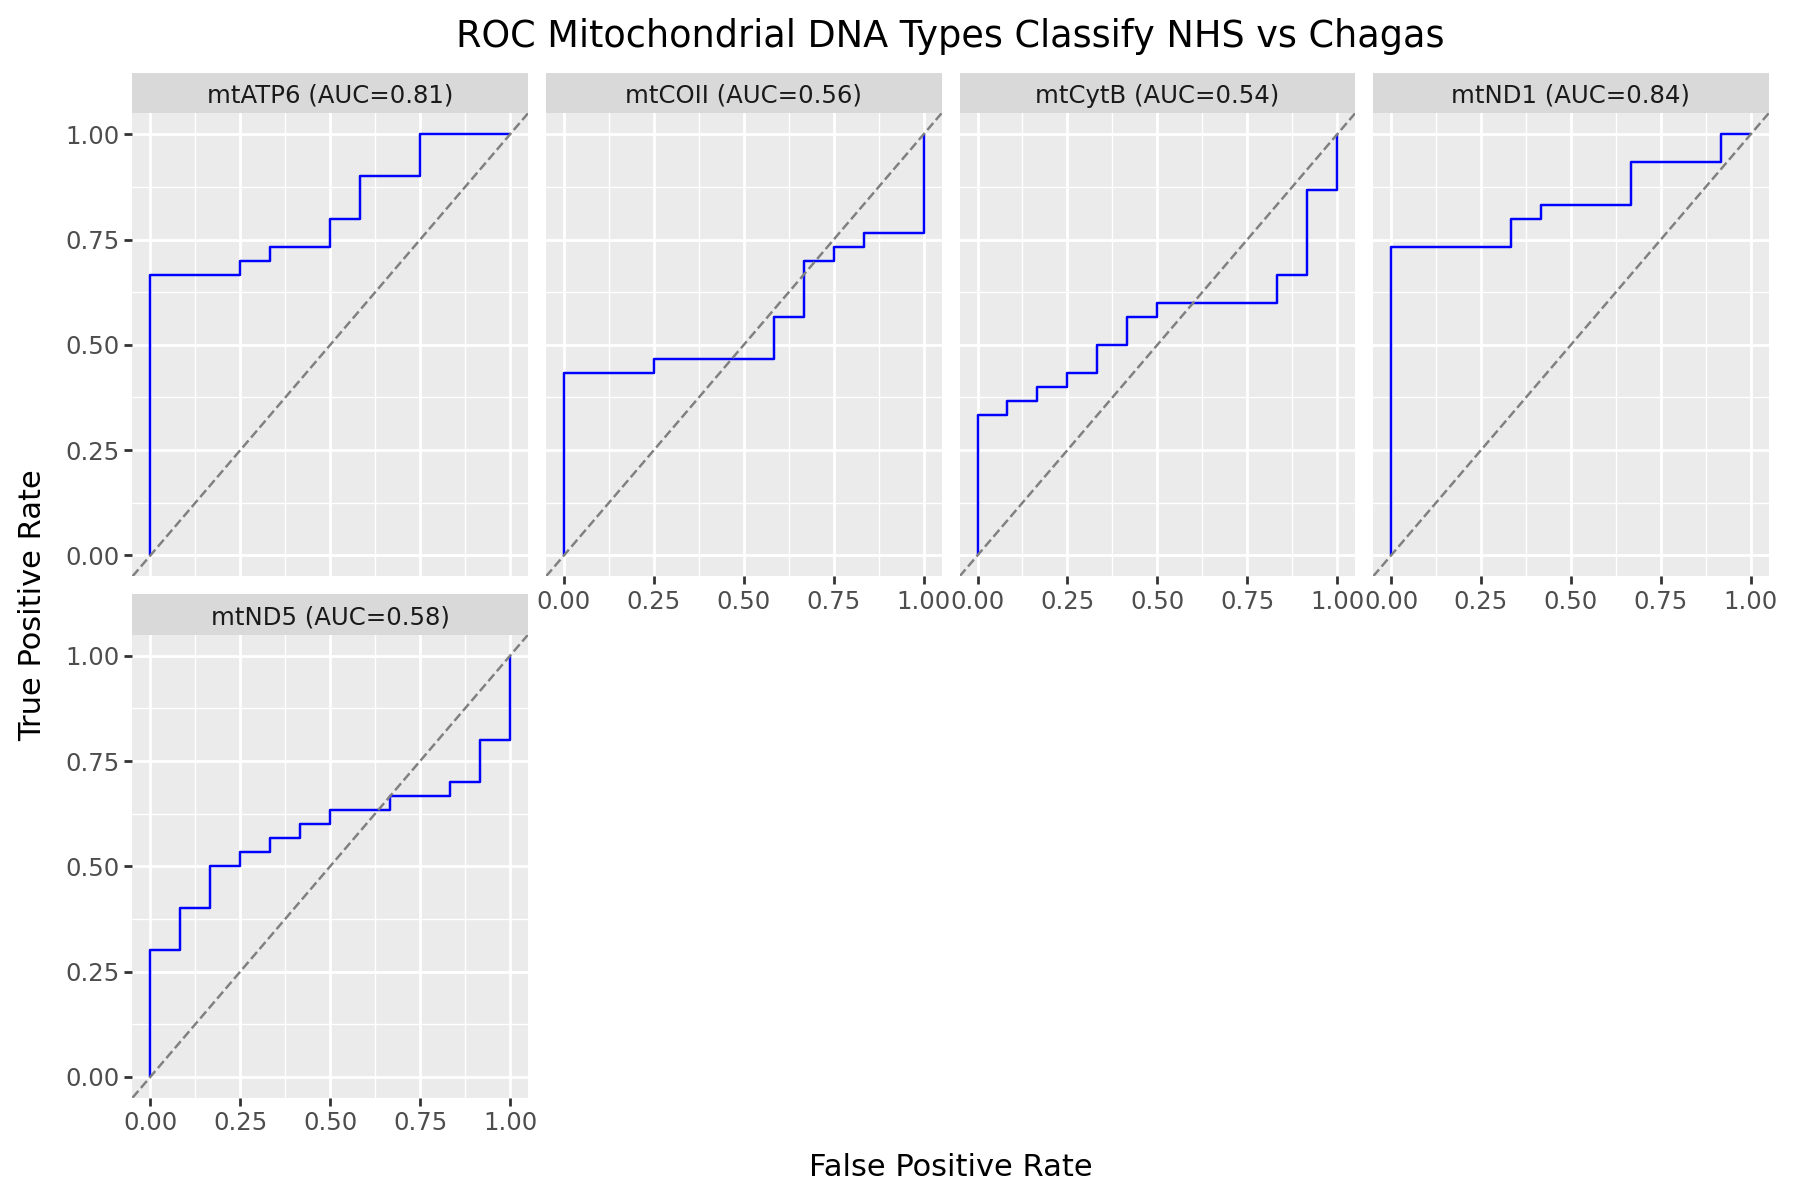

,mtND1,mtND5,mtATP6,mtCOII,mtCytB
0,0.836111,0.583333,0.813889,0.558333,0.544444


In [24]:
# Create Logistic Regression Models and ROC Curves for each Mitochondrial DNA Type
# Chagas vs NHS

train.setup()

for mtDNA in train.mtDNA_biomarkers:
    nhs_mtdna_auc_df.loc[0, mtDNA] = train.chagasLogReg(mtdna_df,'NHS', mtDNA)

train.print_ROC(nhs_mtdna_auc_df,'~Biomarker', "ROC Mitochondrial DNA Types Classify NHS vs Chagas")
nhs_mtdna_auc_df

In [25]:
roc_all = []

nhs_mtdna_cv_df = pd.DataFrame(columns=['Biomarker', 'NHS Mean AUC', 'Std AUC'])

# Loop through protein parameters
for mtDNA in train.mtDNA_biomarkers:
    mean_auc, std_auc = train.chagasLogReg_CV(mtdna_df, outcome='NHS', biomarker=mtDNA, n_splits=5)
    nhs_mtdna_cv_df.loc[len(nhs_mtdna_cv_df)] = [mtDNA, mean_auc, std_auc]
    print(f"{propar}: Mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

# Show summary table
nhs_mtdna_cv_df


etOhDG_Plasma: Mean AUC=0.806 ± 0.186
etOhDG_Plasma: Mean AUC=0.594 ± 0.140
etOhDG_Plasma: Mean AUC=0.844 ± 0.076
etOhDG_Plasma: Mean AUC=0.583 ± 0.226
etOhDG_Plasma: Mean AUC=0.506 ± 0.220


,Biomarker,NHS Mean AUC,Std AUC
0,mtND1,0.805556,0.185924
1,mtND5,0.594444,0.140106
2,mtATP6,0.844444,0.075768
3,mtCOII,0.583333,0.226351
4,mtCytB,0.505556,0.219708


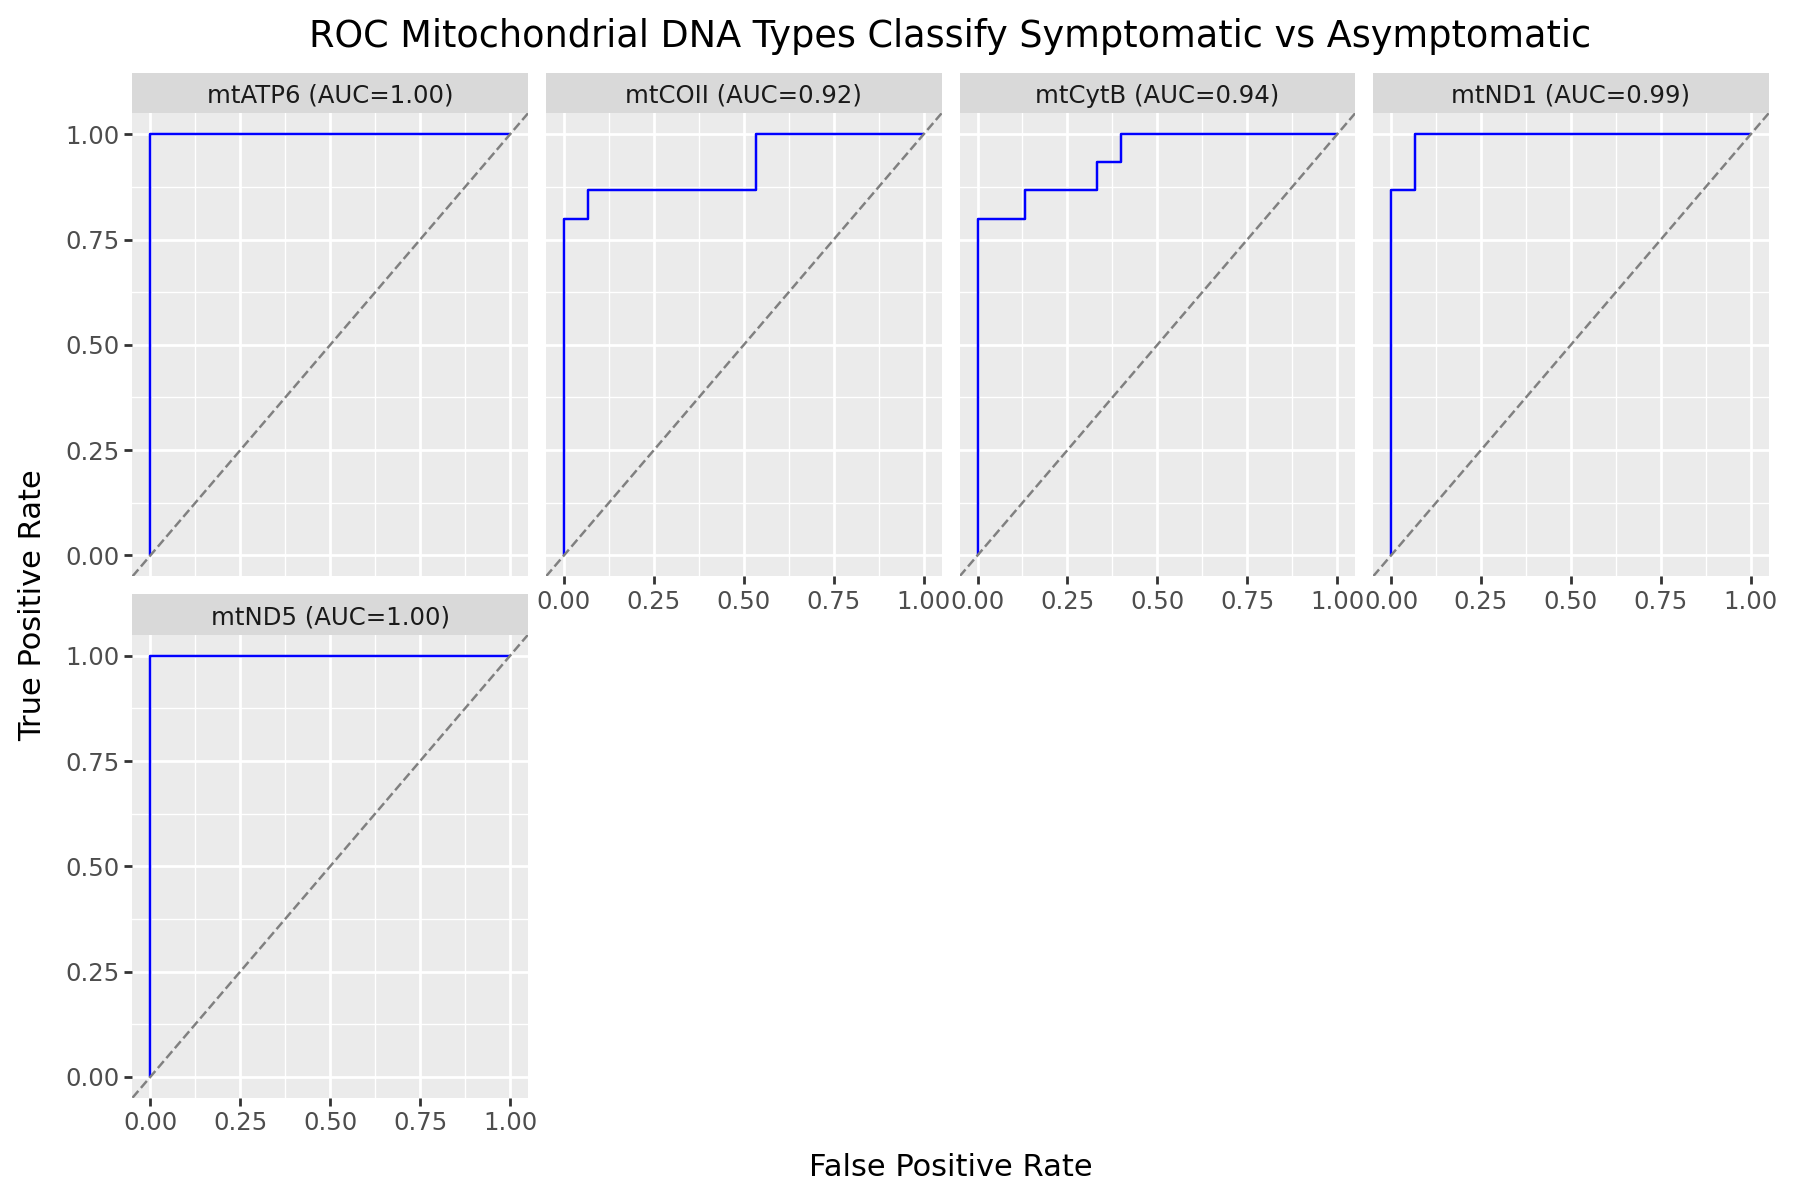

,mtND1,mtND5,mtATP6,mtCOII,mtCytB
0,0.991111,1.0,1.0,0.924444,0.942222


In [26]:
# Create Logistic Regression Models and ROC Curves for each Mitochondrial DNA Type
# Symptomatic vs Asymptomatic

train.setup()

for mtDNA in train.mtDNA_biomarkers:
    sym_mtdna_auc_df.loc[0, mtDNA] = train.chagasLogReg(mtdna_sym,'SYM', mtDNA)

train.print_ROC(sym_mtdna_auc_df,'~Biomarker', "ROC Mitochondrial DNA Types Classify Symptomatic vs Asymptomatic")
sym_mtdna_auc_df

In [27]:
roc_all = []

sym_mtdna_cv_df = pd.DataFrame(columns=['Biomarker', 'SYM Mean AUC', 'Std AUC'])

# Loop through protein parameters
for mtDNA in train.mtDNA_biomarkers:
    mean_auc, std_auc = train.chagasLogReg_CV(mtdna_df, outcome='NHS', biomarker=mtDNA, n_splits=5)
    sym_mtdna_cv_df.loc[len(sym_mtdna_cv_df)] = [mtDNA, mean_auc, std_auc]
    print(f"{mtDNA}: Mean AUC={mean_auc:.3f} ± {std_auc:.3f}")

# Show summary table
sym_mtdna_cv_df

mtND1: Mean AUC=0.806 ± 0.186
mtND5: Mean AUC=0.594 ± 0.140
mtATP6: Mean AUC=0.844 ± 0.076
mtCOII: Mean AUC=0.583 ± 0.226
mtCytB: Mean AUC=0.506 ± 0.220


,Biomarker,SYM Mean AUC,Std AUC
0,mtND1,0.805556,0.185924
1,mtND5,0.594444,0.140106
2,mtATP6,0.844444,0.075768
3,mtCOII,0.583333,0.226351
4,mtCytB,0.505556,0.219708


### Cross Validation Mean AUC Scores

In [31]:
def nhs_classify_mean_auc(df):
    conditions = [
        (df['NHS Mean AUC'] == 1),
        (df['NHS Mean AUC'] < 1) & (df['NHS Mean AUC'] >= 0.8),
        (df['NHS Mean AUC'] < 0.8)
    ]
    
    # Define corresponding values
    choices = ['Perfect Diagnostic', 'Diagnostic', 'Not Diagnostic']
    
    # Create the new column
    df['Classifier'] = np.select(conditions, choices, default='Unknown')

def sym_classify_mean_auc(df):
    conditions = [
        (df['SYM Mean AUC'] == 1),
        (df['SYM Mean AUC'] < 1) & (df['SYM Mean AUC'] >= 0.8),
        (df['SYM Mean AUC'] < 0.8)
    ]
    
    # Define corresponding values
    choices = ['Perfect Prognostic', 'Prognostic', 'Not Prognostic']
    
    # Create the new column
    df['Classifier'] = np.select(conditions, choices, default='Unknown')


nhs_classify_mean_auc(nhs_pp_cv_df)
nhs_classify_mean_auc(nhs_mtdna_cv_df)

sym_classify_mean_auc(sym_pp_cv_df)
sym_classify_mean_auc(sym_mtdna_cv_df)

print(nhs_pp_cv_df)
print(sym_pp_cv_df)
print(nhs_mtdna_cv_df)
print(sym_mtdna_cv_df)


            Biomarker  NHS Mean AUC   Std AUC          Classifier
0      Copeptin_Serum      1.000000  0.000000  Perfect Diagnostic
1    Endostatin_Serum      0.911111  0.084984          Diagnostic
2       HnRNPA1_Serum      0.977778  0.044444          Diagnostic
3     Myostatin_Serum      0.777778  0.172133      Not Diagnostic
4         PARP1_Serum      1.000000  0.000000  Perfect Diagnostic
5        etOhDG_Serum      1.000000  0.000000  Perfect Diagnostic
6     Copeptin_Plasma      1.000000  0.000000  Perfect Diagnostic
7   Endostatin_Plasma      0.950000  0.066667          Diagnostic
8      HnRNPA1_Plasma      0.983333  0.033333          Diagnostic
9    Myostatin_Plasma      0.694444  0.249691      Not Diagnostic
10       PARP1_Plasma      1.000000  0.000000  Perfect Diagnostic
11      etOhDG_Plasma      1.000000  0.000000  Perfect Diagnostic
            Biomarker  SYM Mean AUC   Std AUC          Classifier
0      Copeptin_Serum      0.977778  0.044444          Prognostic
1    Endos

### Visualizing Protein Parameter Results

In [32]:
import pandas as pd

nhs_pp_auc = nhs_pp_auc_df.melt(var_name='biomarker', value_name='auc')
sym_pp_auc = sym_pp_auc_df.melt(var_name='biomarker', value_name='auc')

nhs_pp_auc['test'] = 'nhs'
sym_pp_auc['test'] = 'sym'

for df in [nhs_pp_auc, sym_pp_auc]:
    df['diagnostic'] = 0
    df['prognostic'] = 0

nhs_pp_auc.loc[nhs_pp_auc['auc'] >= 0.8, 'diagnostic'] = 1
sym_pp_auc.loc[sym_pp_auc['auc'] >= 0.8, 'prognostic'] = 1

combined_pp_df = pd.concat(
    [nhs_pp_auc, sym_pp_auc],
    ignore_index=True
)

combined_pp_df['Sample'] = combined_pp_df['biomarker'].apply(lambda x: 'Serum' if 'Serum' in x else 'Plasma')
combined_pp_df['Biomarker'] = (
    combined_pp_df['biomarker']
    .str.replace('_Serum', '', regex=False)
    .str.replace('_Plasma', '', regex=False)
)

combined_pp_df['Group'] = combined_pp_df['test'].map({
    'nhs': 'With vs W/o Chagas',
    'sym': 'Asym vs Sym'
})

def auc_category(auc):
    if auc >= 0.9:
        return 'Excellent (≥ 0.9)'
    elif auc >= 0.8:
        return 'Good (0.8–0.9)'
    else:
        return 'Moderate/Low (< 0.8)'

combined_pp_df['Category'] = combined_pp_df['auc'].apply(auc_category)

agg_df = (
    combined_pp_df
    .groupby(['Biomarker', 'Sample'], as_index=False)
    .agg({
        'diagnostic': 'max',
        'prognostic': 'max'
    })
)

def classify(row):
    if row['diagnostic'] == 1 and row['prognostic'] == 1:
        return 'Both'
    elif row['diagnostic'] == 1:
        return 'Diagnostic'
    elif row['prognostic'] == 1:
        return 'Prognostic'
    else:
        return 'None'

agg_df['Classification'] = agg_df.apply(classify, axis=1)

combined_pp_df = combined_pp_df.merge(
    agg_df[['Biomarker', 'Sample', 'Classification']],
    on=['Biomarker', 'Sample'],
    how='left'
)

protein_parameter_df = combined_pp_df[['Biomarker', 'Sample', 'auc', 'Category', 'Group', 'Classification']]
protein_parameter_df.rename(columns={'auc': 'AUC'}, inplace=True)

protein_parameter_df = protein_parameter_df.sort_values(by=['Biomarker', 'Sample', 'Group']).reset_index(drop=True)
protein_parameter_df['Biomarker_Sample'] = protein_parameter_df['Biomarker'] + '_' + protein_parameter_df['Sample']

print(protein_parameter_df)


     Biomarker  Sample       AUC              Category               Group  \
0     Copeptin  Plasma       1.0     Excellent (≥ 0.9)         Asym vs Sym   
1     Copeptin  Plasma       1.0     Excellent (≥ 0.9)  With vs W/o Chagas   
2     Copeptin   Serum  0.982222     Excellent (≥ 0.9)         Asym vs Sym   
3     Copeptin   Serum       1.0     Excellent (≥ 0.9)  With vs W/o Chagas   
4   Endostatin  Plasma  0.915556     Excellent (≥ 0.9)         Asym vs Sym   
5   Endostatin  Plasma  0.951389     Excellent (≥ 0.9)  With vs W/o Chagas   
6   Endostatin   Serum  0.891111        Good (0.8–0.9)         Asym vs Sym   
7   Endostatin   Serum  0.922222     Excellent (≥ 0.9)  With vs W/o Chagas   
8      HnRNPA1  Plasma  0.613333  Moderate/Low (< 0.8)         Asym vs Sym   
9      HnRNPA1  Plasma  0.984722     Excellent (≥ 0.9)  With vs W/o Chagas   
10     HnRNPA1   Serum  0.706667  Moderate/Low (< 0.8)         Asym vs Sym   
11     HnRNPA1   Serum  0.988889     Excellent (≥ 0.9)  With vs 

C:\Users\Carlos\AppData\Local\Temp\ipykernel_5868\3053992864.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


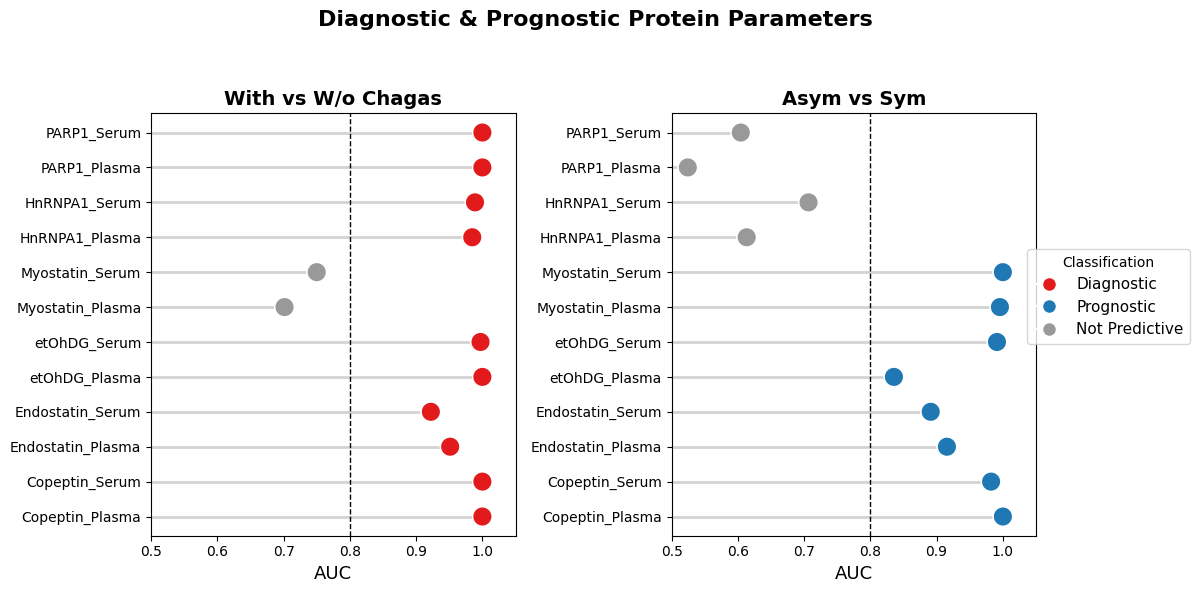

In [33]:

label_order = [
    'Copeptin_Plasma',
    'Copeptin_Serum',
    'Endostatin_Plasma',
    'Endostatin_Serum',
    'etOhDG_Plasma',
    'etOhDG_Serum',
    'Myostatin_Plasma',
    'Myostatin_Serum',
    'HnRNPA1_Plasma',
    'HnRNPA1_Serum',
    'PARP1_Plasma',
    'PARP1_Serum'
]

eda.lolipop_plot(
    df=protein_parameter_df,
    biomarker_col='Biomarker_Sample',
    value_col='AUC',
    group_col='Group',
    threshold=0.8,
    title='Diagnostic & Prognostic Protein Parameters',
    label_order_list=label_order
)

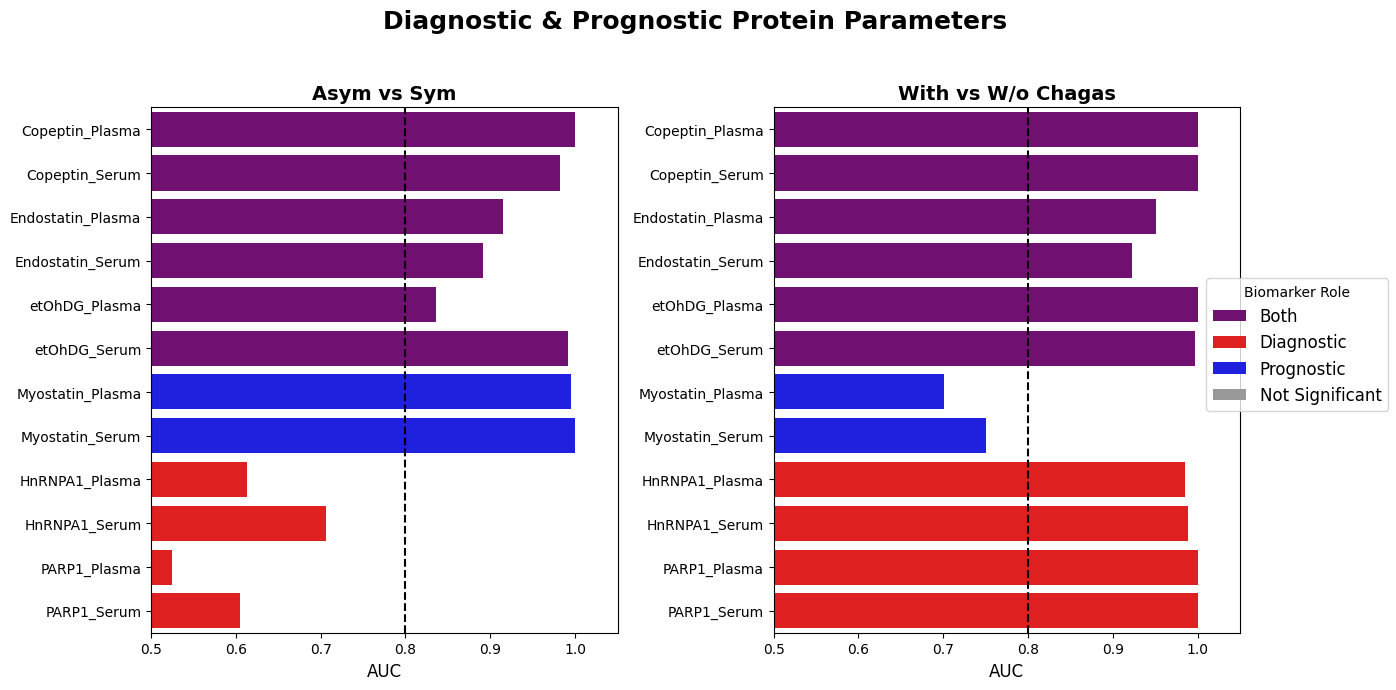

In [34]:

label_order = [
    'Copeptin_Plasma',
    'Copeptin_Serum',
    'Endostatin_Plasma',
    'Endostatin_Serum',
    'etOhDG_Plasma',
    'etOhDG_Serum',
    'Myostatin_Plasma',
    'Myostatin_Serum',
    'HnRNPA1_Plasma',
    'HnRNPA1_Serum',
    'PARP1_Plasma',
    'PARP1_Serum'
]
eda.biomarker_barplot(
    df=protein_parameter_df,
    biomarker_col='Biomarker_Sample',
    value_col='AUC',
    group_col='Group',
    classification_col='Classification',
    title='Diagnostic & Prognostic Protein Parameters',
    label_order=label_order,
    threshold=0.8
)

### Visualizating MtDNA AUC Results

In [35]:
nhs_mtdna_auc = nhs_mtdna_auc_df.melt(var_name='biomarker', value_name='auc')
sym_mtdna_auc = sym_mtdna_auc_df.melt(var_name='biomarker', value_name='auc')

nhs_mtdna_auc['test'] = 'nhs'
sym_mtdna_auc['test'] = 'sym'

for df in [nhs_mtdna_auc, sym_mtdna_auc]:
    df['Diagnostic'] = 0
    df['Prognostic'] = 0

nhs_mtdna_auc.loc[nhs_mtdna_auc['auc'] >= 0.8, 'Diagnostic'] = 1
sym_mtdna_auc.loc[sym_mtdna_auc['auc'] >= 0.8, 'Prognostic'] = 1

combined_mtdna_df = pd.concat(
    [nhs_mtdna_auc, sym_mtdna_auc],
    ignore_index=True
)


combined_mtdna_df['Group'] = combined_mtdna_df['test'].map({
    'nhs': 'With vs W/o Chagas',
    'sym': 'Asym vs Sym'
})


combined_mtdna_df.loc[(combined_mtdna_df['Diagnostic'] == 1) & (combined_mtdna_df['Prognostic'] == 0), 'Classification'] = 'Diagnostic'
combined_mtdna_df.loc[(combined_mtdna_df['Diagnostic'] == 0) & (combined_mtdna_df['Prognostic'] == 1), 'Classification'] = 'Prognostic'
combined_mtdna_df.loc[(combined_mtdna_df['Diagnostic'] == 1) & (combined_mtdna_df['Prognostic'] == 1), 'Classification'] = 'Both'
combined_mtdna_df.loc[(combined_mtdna_df['Diagnostic'] == 0) & (combined_mtdna_df['Prognostic'] == 0), 'Classification'] = 'Not Significant'

# Compute overall biomarker-level classifier
biomarker_summary = (
    combined_mtdna_df
    .groupby("biomarker")[["Diagnostic", "Prognostic"]]
    .max()  # 1 if it's significant in either NHS or SYM
    .reset_index()
)

def classify_biomarker(row):
    if row["Diagnostic"] == 1 and row["Prognostic"] == 1:
        return "Both"
    elif row["Diagnostic"] == 1:
        return "Diagnostic"
    elif row["Prognostic"] == 1:
        return "Prognostic"
    else:
        return "Not Significant"

biomarker_summary["Classifier"] = biomarker_summary.apply(classify_biomarker, axis=1)

# Merge back to the main dataframe
combined_mtdna_df = combined_mtdna_df.merge(
    biomarker_summary[["biomarker", "Classifier"]],
    on="biomarker",
    how="left"
)

combined_mtdna_df



,biomarker,auc,test,Diagnostic,Prognostic,Group,Classification,Classifier
0,mtND1,0.836111,nhs,1,0,With vs W/o Chagas,Diagnostic,Both
1,mtND5,0.583333,nhs,0,0,With vs W/o Chagas,Not Significant,Prognostic
2,mtATP6,0.813889,nhs,1,0,With vs W/o Chagas,Diagnostic,Both
3,mtCOII,0.558333,nhs,0,0,With vs W/o Chagas,Not Significant,Prognostic
4,mtCytB,0.544444,nhs,0,0,With vs W/o Chagas,Not Significant,Prognostic
5,mtND1,0.991111,sym,0,1,Asym vs Sym,Prognostic,Both
6,mtND5,1.0,sym,0,1,Asym vs Sym,Prognostic,Prognostic
7,mtATP6,1.0,sym,0,1,Asym vs Sym,Prognostic,Both
8,mtCOII,0.924444,sym,0,1,Asym vs Sym,Prognostic,Prognostic
9,mtCytB,0.942222,sym,0,1,Asym vs Sym,Prognostic,Prognostic


  biomarker       auc test  Diagnostic  Prognostic               Group  \
0     mtND1  0.836111  nhs           1           0  With vs W/o Chagas   
1     mtND5  0.583333  nhs           0           0  With vs W/o Chagas   
2    mtATP6  0.813889  nhs           1           0  With vs W/o Chagas   
3    mtCOII  0.558333  nhs           0           0  With vs W/o Chagas   
4    mtCytB  0.544444  nhs           0           0  With vs W/o Chagas   
5     mtND1  0.991111  sym           0           1         Asym vs Sym   
6     mtND5       1.0  sym           0           1         Asym vs Sym   
7    mtATP6       1.0  sym           0           1         Asym vs Sym   
8    mtCOII  0.924444  sym           0           1         Asym vs Sym   
9    mtCytB  0.942222  sym           0           1         Asym vs Sym   

    Classification  Classifier  
0       Diagnostic        Both  
1  Not Significant  Prognostic  
2       Diagnostic        Both  
3  Not Significant  Prognostic  
4  Not Significant  

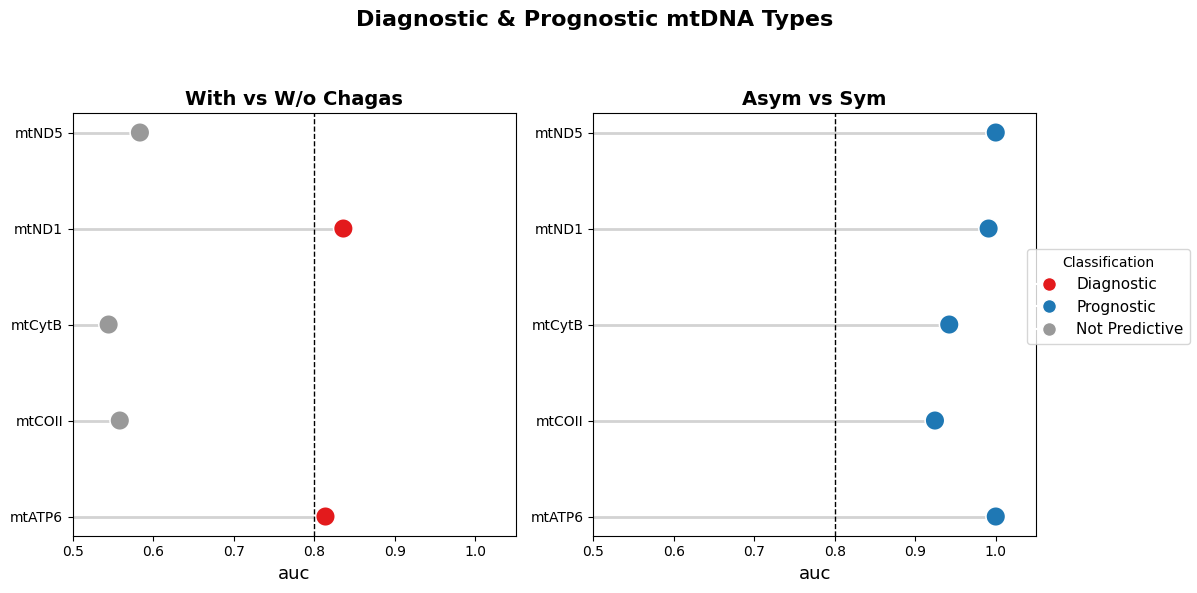

In [36]:
import matplotlib.pyplot as plt
import statsmodels as sm
import seaborn as sns
import pandas as pd

df = combined_mtdna_df.copy()  # use the real dataframe
df['Label'] = df['biomarker']
auc_threshold = 0.8
label_order = df['Label'].unique()

print(combined_mtdna_df)

eda.lolipop_plot(
    df=combined_mtdna_df,
    biomarker_col='biomarker',
    value_col='auc',
    group_col='Group',
    threshold=0.8,
    title='Diagnostic & Prognostic mtDNA Types'
)


  biomarker       auc test  Diagnostic  Prognostic               Group  \
0     mtND1  0.836111  nhs           1           0  With vs W/o Chagas   
1     mtND5  0.583333  nhs           0           0  With vs W/o Chagas   
2    mtATP6  0.813889  nhs           1           0  With vs W/o Chagas   
3    mtCOII  0.558333  nhs           0           0  With vs W/o Chagas   
4    mtCytB  0.544444  nhs           0           0  With vs W/o Chagas   
5     mtND1  0.991111  sym           0           1         Asym vs Sym   
6     mtND5       1.0  sym           0           1         Asym vs Sym   
7    mtATP6       1.0  sym           0           1         Asym vs Sym   
8    mtCOII  0.924444  sym           0           1         Asym vs Sym   
9    mtCytB  0.942222  sym           0           1         Asym vs Sym   

    Classification  Classifier  
0       Diagnostic        Both  
1  Not Significant  Prognostic  
2       Diagnostic        Both  
3  Not Significant  Prognostic  
4  Not Significant  

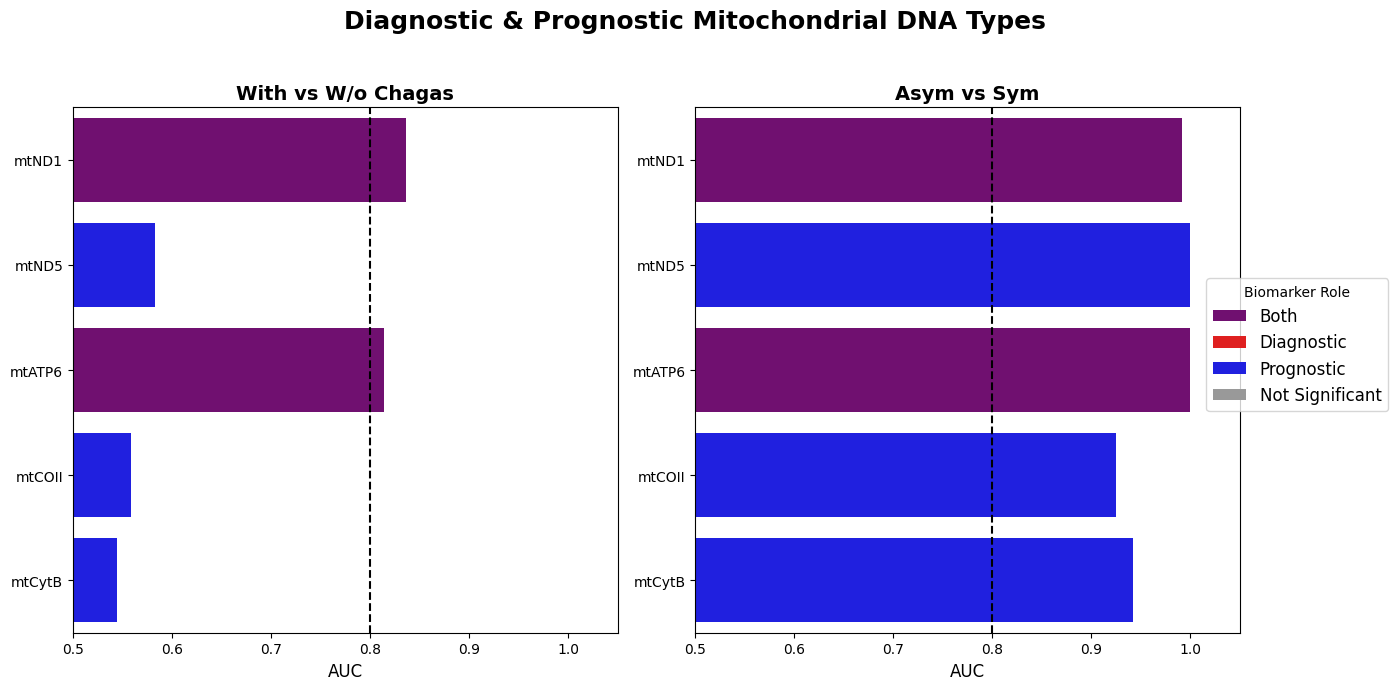

In [37]:
print(combined_mtdna_df)

eda.biomarker_barplot(
    df=combined_mtdna_df,
    biomarker_col='biomarker',
    value_col='auc',
    group_col='Group',
    classification_col='Classifier',
    title='Diagnostic & Prognostic Mitochondrial DNA Types',
    label_order= label_order,
    threshold=0.8
)

### Findings

- The most reliable Diagnostic biomarkers are **Copetin, Myostatin and PARP1**. Based on cross validated AUC scores.

- The most reliable Prognostic biomarkers are **mtATP6 and Myostatin**. Based on cross validated AUC scores.

- Biomarkers that are both Diagnostic and Prognostic : **Copeptin, Endostatin, etOhDG , mtND5, mtATP6**


- **Perfect Diagnostics: Mean AUC == 1**
Protein Parameters: Copeptin_Serum, Copeptin_Plasma, PARP1_Serum, PARP1_Plasma, etODG_Serum, etOhDG_Plasma
Mitochondrial DNA Types:

- **Diagnostics: Mean AUC >= 0.8**
Protein Parameters: Copeptin_Serum, Copeptin_Plasma, PARP1_Serum, PARP1_Plasma, etODG_Serum, etOhDG_Plasma, Endostatin_Serum, Endostatin_Plasma, HnRNPA1_Serum, HnRNPA1_Plasma
Mitochondrial DNA Types: mtATP6, mtND1

- **Not Diagnostic: Mean AUC < 0.8**
Protein Parameters: Myostatin_Serum, Myostatin_Plasma
Mitochondrial DNA Types: mtND5, mtCOII, mtCytB


- **Perfect Prognostics**: Mean AUC == 1
Protein Parameters: Myostatin_Serum, etOhDG_Serum, Copeptin_Plasma
Mitochondrial DNA Types:

- **Prognostics: Mean AUC >= 0.8**
Protein Parameters: Myostatin_Serum, etOhDG_Serum, Copeptin_Plasma, Copeptin_Serum, Endostatin_Serum, Endostatin_Plasma, Myostatin_Plasma
Mitochondrial DNA Types: mtND1, mtATP6

- **Not Prognostics: Mean AUC >= 0.8**
Protein Parameters: HnRNPA1_Serum, HnRNPA1_Plasma, PARP1_Serum, PARP1_Plasma, etOhDG_Plasma
Mitochondrial DNA Types: mtND5, mtCOII, mtCytB


- There was no statistically significant difference between protein parameters derived from Plasma versus from Serum. This may be expected to a geneticist.


### Further Questions for Geneticists
1. Does gene expression vary depending on whether it is derived from Serum or Plasma? Was the lack of significant difference between the two expected?

2. Is it more economical for a blood test to derive data from few or a single biomarker? Or is it just as efficient to look at all 6 protein paramters in a single DNA test?
If so, only the biomarkers with the highest sucess rate should be used.

3. Are MtDNA Types and Protein Parameters equally attainable in blood test? Or is the use of one perferable to another?
This is important considering there are no purley diagnostic mtDNA Types.

4. Are biomarkers that are both diagnostic and prognostic less desirable for a bloodtest than mutually exclusive biomarkers?
Over half the biomarkers were both diagnostic and prognostic.